In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data_path = "./drive/MyDrive/wafer/wm811k/"
print(os.listdir(data_path))

['LSWMD.pkl', 'y_3000.npy', 'x_3000.npy', 'y_3500.npy', 'x_3500.npy', 'x_3500_128.npy', 'y_3500_128.npy']


In [3]:
df = pd.read_pickle(data_path + "LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
def fTypeConvertor(fType):
  if len(fType) == 0:
    return None
  if fType[0][0] == 'none':
    return None
  return fType[0][0]

In [6]:
df['fType'] = df['failureType'].apply(fTypeConvertor)
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,fType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],None
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],None
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],None
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],None
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],None


In [7]:
df.groupby('fType').count()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
fType,,,,,,
Center,4294,4294,4294,4294,4294,4294
Donut,555,555,555,555,555,555
Edge-Loc,5189,5189,5189,5189,5189,5189
Edge-Ring,9680,9680,9680,9680,9680,9680
Loc,3593,3593,3593,3593,3593,3593
Near-full,149,149,149,149,149,149
Random,866,866,866,866,866,866
Scratch,1193,1193,1193,1193,1193,1193


In [8]:
df = df[df['fType'] != None]

<h1>Data Set</h1>

In [9]:
import cv2
from tqdm import tqdm

np.random.seed(0)

In [10]:
mapping_label = {'Center' : 0,
                     'Donut' : 1,
                     'Edge-Loc': 2,
                     'Edge-Ring':3,
                     'Loc':4,
                     'Random':5,
                     'Scratch': 6}

In [11]:
def preprocessing(df, label, ratio, image_size, max_num):
  sub_df = df[df['fType'] == label]
  
  max_inputs = 1100
  
  resized_img = np.ones((max_inputs, image_size, image_size))
  inputs = np.zeros((max_inputs, 3, image_size, image_size))
  labels = np.zeros((max_inputs, 7))
  class_idx = mapping_label[label]
  labels[:, class_idx] = 1

  num_inputs = 0

  for i in tqdm(range(len(sub_df))):
      height = len(sub_df.iloc[i,:]['waferMap'])
      width = len(sub_df.iloc[i,:]['waferMap'][0])
      if height / width < 1 + ratio and height / width > 1 - ratio:
        resized_img[num_inputs] = cv2.resize(sub_df.iloc[i,:]['waferMap'], dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC).reshape(1, image_size, image_size)
        num_inputs += 1

  for w in range(num_inputs):
    for i in range(image_size):
      for j in range(image_size):
        if int(resized_img[w, i, j]) >= 3:
          inputs[w, 2, i, j] = 1
        else:
          inputs[w, int(resized_img[w, i, j]), i, j] = 1

  x = inputs[:num_inputs]
  y = labels[:num_inputs]

  print(f"length : {len(x)}")

  if(len(x) > max_num):
    sample = np.random.choice(len(x), max_num)
    x = x[sample]
    y = y[sample]
  else:
    print("please use bigger threshold ratio")

  del resized_img
  del inputs
  del labels

  return x, y

In [12]:
IMAGE_SIZE = 128
MAX_NUM = 500

In [13]:
x_center, y_center = preprocessing(df, "Center", 0.001, IMAGE_SIZE, MAX_NUM)
x_edge_loc, y_edge_loc = preprocessing(df, "Edge-Loc", 0.001, IMAGE_SIZE, MAX_NUM)
x_loc, y_loc = preprocessing(df, "Loc", 0.001, IMAGE_SIZE, MAX_NUM)
x_scratch, y_scratch = preprocessing(df, "Scratch", 0.08, IMAGE_SIZE, MAX_NUM)
x_donut, y_donut = preprocessing(df, "Donut", 0.17, IMAGE_SIZE, MAX_NUM)
x_edge_ring, y_edge_ring = preprocessing(df, "Edge-Ring", 0.001, IMAGE_SIZE, MAX_NUM)
x_random, y_random = preprocessing(df, "Random", 0.08, IMAGE_SIZE, MAX_NUM)

100%|██████████| 4294/4294 [00:02<00:00, 1981.66it/s]


length : 803


100%|██████████| 5189/5189 [00:02<00:00, 1992.76it/s]


length : 680


100%|██████████| 3593/3593 [00:01<00:00, 1959.79it/s]


length : 634


100%|██████████| 1193/1193 [00:00<00:00, 1625.36it/s]


length : 541


100%|██████████| 555/555 [00:00<00:00, 1253.44it/s]


length : 504


100%|██████████| 9680/9680 [00:04<00:00, 2072.90it/s]


length : 1093


100%|██████████| 866/866 [00:00<00:00, 1532.85it/s]


length : 516


In [14]:
y_edge_ring[0]

array([0., 0., 0., 1., 0., 0., 0.])

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 1. 0.]')

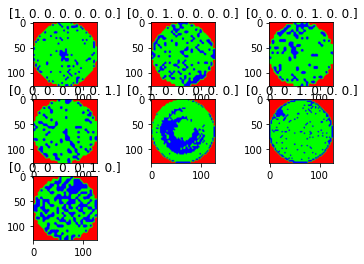

In [15]:
fig = plt.figure()

ax0 = fig.add_subplot(3,3,1)
ax1 = fig.add_subplot(3,3,2)
ax2 = fig.add_subplot(3,3,3)
ax3 = fig.add_subplot(3,3,4)
ax4 = fig.add_subplot(3,3,5)
ax5 = fig.add_subplot(3,3,6)
ax6 = fig.add_subplot(3,3,7)

ax0.imshow(np.transpose(x_center[0], (1,2,0)))
ax0.set_title(y_center[0])
ax1.imshow(np.transpose(x_edge_loc[0], (1,2,0)))
ax1.set_title(y_edge_loc[0])
ax2.imshow(np.transpose(x_loc[0], (1,2,0)))
ax2.set_title(y_loc[0])
ax3.imshow(np.transpose(x_scratch[0], (1,2,0)))
ax3.set_title(y_scratch[0])
ax4.imshow(np.transpose(x_donut[0], (1,2,0)))
ax4.set_title(y_donut[0])
ax5.imshow(np.transpose(x_edge_ring[0], (1,2,0)))
ax5.set_title(y_edge_ring[0])
ax6.imshow(np.transpose(x_random[0], (1,2,0)))
ax6.set_title(y_random[0])

In [16]:
x_merge = np.concatenate([x_center, x_donut, x_edge_loc, x_edge_ring, x_loc, x_random, x_scratch])
y_merge = np.concatenate([y_center, y_donut, y_edge_loc, y_edge_ring, y_loc, y_random, y_scratch])

In [17]:
print(len(x_merge))
print(len(y_merge))

3500
3500


In [18]:
print(f"x_merge.shape : {x_merge.shape}")
print(f"y_merge.shape : {y_merge.shape}")

x_merge.shape : (3500, 3, 128, 128)
y_merge.shape : (3500, 7)


In [20]:
print(f"x_{len(x_merge)}_{IMAGE_SIZE}.npy")
print(f"y_{len(y_merge)}_{IMAGE_SIZE}.npy")

np.save(f"./drive/MyDrive/wafer/wm811k/x_{len(x_merge)}_{IMAGE_SIZE}.npy", x_merge)
np.save(f"./drive/MyDrive/wafer/wm811k/y_{len(y_merge)}_{IMAGE_SIZE}.npy", y_merge)

x_3500_128.npy
y_3500_128.npy
